In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pandas import read_csv
import wordcloud
from wordcloud import WordCloud,STOPWORDS

### so that u dont have warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Reading restaurants data
data_path = '/content/drive/MyDrive/NLP project/zomato.csv'
df= read_csv(data_path)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (51717, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


**overview from the data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [5]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [6]:
feature_na=[feature for feature in df.columns if df[feature].isnull().sum()>0]
feature_na

['rate',
 'phone',
 'location',
 'rest_type',
 'dish_liked',
 'cuisines',
 'approx_cost(for two people)']

In [7]:
#% of missing values
import numpy as np
for feature in feature_na:
    print('{} :-          {} % missing values'.format(feature,np.round(df[feature].isnull().sum()/len(df)*100,4)))

rate :-          15.0337 % missing values
phone :-          2.3358 % missing values
location :-          0.0406 % missing values
rest_type :-          0.4389 % missing values
dish_liked :-          54.2916 % missing values
cuisines :-          0.087 % missing values
approx_cost(for two people) :-          0.669 % missing values


In [8]:
# Making a copy of the data to work on
data = df.copy()

In [9]:
## Lets aggregate data of listed_in(type) into list
grouped=data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
grouped

listed_in(type)
name                                         address                                                                                              
#FeelTheROLL                                 Opposite Mantri Commercio, Outer Ring Road, Dev...                               [Delivery, Delivery]
#L-81 Cafe                                   Sector 6, HSR Layout, HSR                           [Delivery, Dine-out, Delivery, Dine-out, Deliv...
#Vibes Restro                                Marasur Gate, Chandapura - Anekal Road, Near Al...                       [Buffet, Delivery, Dine-out]
#refuel                                      7, Ground Floor, RR Commercial Complex, Akshay ...                        [Cafes, Delivery, Dine-out]
'Brahmins' Thatte Idli                       19, 1st main, 2nd cross, 3rd stage, 3rd block, ...                                         [Dine-out]
...                                                                                                                                            ...
nu.tree                                      47/7 First floor, DoddaThogur Road, Near Velank...                                         [Delivery]
                                             Ground Floor-Lobby Area, Brigade IRV Centre, Na...                     [Delivery, Delivery, Delivery]
re:cess - Hilton Bangalore Embassy GolfLinks Hilton Bangalore Embassy GolfLinks, Embassy Gol...                [Dine-out, Dine-out, Pubs and bars]
repEAT Hub                                   67/4, Bhoganahalli Road, JCR Layout, Panathur, ...                               [Delivery, Dine-out]
sCoolMeal                                    197/293-3, 32nd Main, 1st Stage, BTM, Bangalore     [Delivery, Delivery, Delivery, Delivery, Deliv...

[12499 rows x 1 columns]

In [10]:
## merge your both the dataframe
newdata = pd.merge(grouped, data, on = (["name", "address"]))
newdata

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city)
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur
1,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4 /5,7,+91 9108342079\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Sarjapur Road
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM
3,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Dine-out,BTM
4,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,HSR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51712,sCoolMeal,"197/293-3, 32nd Main, 1st Stage, BTM, Bangalore","[Delivery, Delivery, Delivery, Delivery, Deliv...",https://www.zomato.com/bangalore/scoolmeal-btm...,No,No,NaN,0,+91 8971958284,BTM,"Takeaway, Delivery",NaN,"North Indian, South Indian, Chinese, Pizza",300,[],[],Delivery,BTM
51713,sCoolMeal,"197/293-3, 32nd Main, 1st Stage, BTM, Bangalore","[Delivery, Delivery, Delivery, Delivery, Deliv...",https://www.zomato.com/bangalore/scoolmeal-btm...,No,No,NaN,0,+91 8971958284,BTM,"Takeaway, Delivery",NaN,"North Indian, South Indian, Chinese, Pizza",300,[],[],Delivery,Koramangala 4th Block
51714,sCoolMeal,"197/293-3, 32nd Main, 1st Stage, BTM, Bangalore","[Delivery, Delivery, Delivery, Delivery, Deliv...",https://www.zomato.com/bangalore/scoolmeal-btm...,No,No,NaN,0,+91 8971958284,BTM,"Takeaway, Delivery",NaN,"North Indian, South Indian, Chinese, Pizza",300,[],[],Delivery,Koramangala 5th Block
51715,sCoolMeal,"197/293-3, 32nd Main, 1st Stage, BTM, Bangalore","[Delivery, Delivery, Delivery, Delivery, Deliv...",https://www.zomato.com/bangalore/scoolmeal-btm...,No,No,NaN,0,+91 8971958284,BTM,"Takeaway, Delivery",NaN,"North Indian, South Indian, Chinese, Pizza",300,[],[],Delivery,Koramangala 6th Block


In [11]:
newdata['listed_in(type)_y'].dtype

dtype('O')

In [12]:
newdata.shape

(51717, 18)

In [13]:
#remove duplicates from data.
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_y"], inplace = True)
newdata = newdata.reset_index(drop = True)
newdata.shape


(20915, 18)

In [14]:
newdata['rate'].unique() 

array(['3.4/5', '3.9/5', nan, '3.7/5', '3.2/5', '3.5/5', '4.6/5', '4.1/5',
       '4.2 /5', '4.3 /5', '4.2/5', '4.0/5', '4.0 /5', '3.9 /5', '4.1 /5',
       '3.7 /5', '4.3/5', '3.1 /5', '3.6/5', '3.1/5', '3.3/5', '3.0/5',
       '3.5 /5', '4.4/5', '4.5 /5', 'NEW', '3.3 /5', '3.8/5', '3.2 /5',
       '3.6 /5', '4.5/5', '3.8 /5', '3.4 /5', '2.7/5', '2.7 /5', '2.8/5',
       '3.0 /5', '2.9/5', '2.5 /5', '2.9 /5', '2.8 /5', '4.9/5', '4.7/5',
       '4.8/5', '4.8 /5', '4.4 /5', '1.8/5', '2.4/5', '2.1/5', '2.5/5',
       '-', '2.2/5', '4.7 /5', '2.6/5', '4.6 /5', '4.9 /5', '2.3/5',
       '2.0 /5', '2.3 /5', '2.6 /5', '2.4 /5', '2.0/5'], dtype=object)

In [15]:
# Transforming the ratings column 
newdata["rating"] = newdata["rate"].str[:3] # Extracting the first three characters of each string in "rate"
newdata.head(2)

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('Rated 5.0', ""RATED\n Had an egg chicken ro...",[],Delivery,Bellandur,3.4
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('Rated 4.0', 'RATED\n This little cafe is s...",[],Delivery,BTM,3.9


In [16]:
newdata["rating"].replace('NEW',0,inplace=True)
newdata["rating"].replace('-',0,inplace=True)
newdata["rating"] = pd.to_numeric(newdata["rating"])
newdata['rating'].unique()


array([3.4, 3.9, nan, 3.7, 3.2, 3.5, 4.6, 4.1, 4.2, 4.3, 4. , 3.1, 3.6,
       3.3, 3. , 4.4, 4.5, 0. , 3.8, 2.7, 2.8, 2.9, 2.5, 4.9, 4.7, 4.8,
       1.8, 2.4, 2.1, 2.2, 2.6, 2.3, 2. ])

In [17]:
newdata['rating'].isnull().sum()

3383

In [ ]:
# Discretizing the ratings into a categorical feature with 4 levels
## ie if less than 3, assign 0
## ie if less than 3.5, assign 1
## ie if less than 4.0, assign 2
## ie if less than 5.o assign 3

## We can think of these as 0-Very Low, 1-Low, 2-Medium and 3-High.

In [18]:
newdata.isnull().sum()

name                               0
address                            0
listed_in(type)_x                  0
url                                0
online_order                       0
book_table                         0
rate                            3383
votes                              0
phone                            399
location                          12
rest_type                        106
dish_liked                     11999
cuisines                          23
approx_cost(for two people)       98
reviews_list                       0
menu_item                          0
listed_in(type)_y                  0
listed_in(city)                    0
rating                          3383
dtype: int64

In [19]:
newdata.shape

(20915, 19)

**bins = [1, 3.25, 4.1, 5.0]**

**it means if it is b/w 1 to 3.25, assign label as 0**

**if b/w 3.25 to 4.1, assign label as 1 & so on**

In [20]:
newdata["rating"]=pd.cut(newdata["rating"], bins = [1, 3.25, 4.1, 5.0], labels = ["0", "1", "2"])

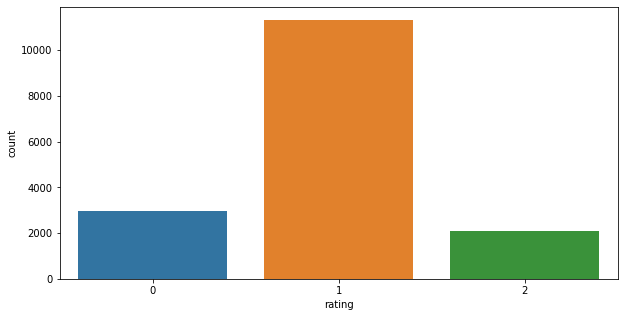

In [21]:
# Visualizing the rating class distribution
plt.figure(figsize = (10, 5))
sns.countplot(newdata["rating"])


In [22]:
# Summary statistics
newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
count,20915,20915,20915,20915,20915,20915,17532,20915.000000,20516,20903,20809,8916,20892,20817,20915,20915,20915,20915,16391
unique,8792,11495,927,20915,2,2,61,NaN,11999,93,93,4502,2630,70,12660,3693,7,30,3
top,Cafe Coffee Day,Delivery Only,"[Delivery, Dine-out]",https://www.zomato.com/bangalore/feeltheroll-b...,Yes,No,3.9/5,NaN,080 43334333,Whitefield,Quick Bites,Biryani,North Indian,300,[],[],Delivery,BTM,1
freq,78,36,2418,1,11605,18615,1181,NaN,93,1462,8007,78,1174,3005,3524,16766,9355,2379,11321
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.105427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.954538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
newdata['reviews_list'][0]

'[(\'Rated 5.0\', "RATED\\n  Had an egg chicken roll and a paneer roll... Really yummy... A must visit place... It would be good if you guys can keep the shop open on Sunday\'s as well.. Good luck... :-)"), (\'Rated 5.0\', \'RATED\\n  Not just the Roll but the filling tastes great. I would highly recommend to others to try their rolls. Owners hospitality is also good and very friendly.\'), (\'Rated 4.5\', \'RATED\\n  Very nice place complete value for money ? Highly recommend.Must visit for any foodie . I would recommend the egg chicken roll . #feeltheroll\'), (\'Rated 5.0\', \'RATED\\n  Had an amazing mouth-watering ?chicken roll?Worth every bite..A must try for every foodie?A variety of rolls and sandwiches are available as well .. A budding rafflesia ?\')]'

In [24]:
sample=newdata.sample(n=4000)
total_review=' '
for review in sample['reviews_list']:
    review=review.lower()
    review=re.sub('[^a-zA-Z]', ' ',review)
    review=re.sub('rated', ' ',review)
    review=re.sub('x',' ',review) 
    review=re.sub(' +',' ',review)
    total_review=total_review + str(review)
 

**generate wordcloud**

(-0.5, 799.5, 799.5, -0.5)

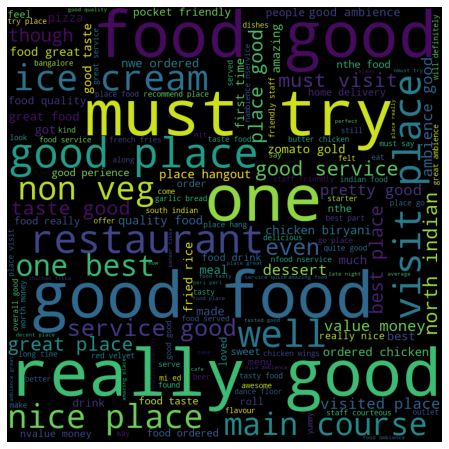

In [25]:
stopwords=set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(total_review) 
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 

In [26]:
from nltk.corpus import RegexpTokenizer as regextoken

In [27]:
# Converting all the text to lowercase
newdata["reviews_list"] = newdata["reviews_list"].apply(lambda x: x.lower())

In [28]:
##  Creating a regular expression tokenizer that have only alphabets , ie it remove all the special characters

tokenizer = regextoken("[a-zA-Z]+") 

In [29]:
newdata["reviews_list"][0]

'[(\'rated 5.0\', "rated\\n  had an egg chicken roll and a paneer roll... really yummy... a must visit place... it would be good if you guys can keep the shop open on sunday\'s as well.. good luck... :-)"), (\'rated 5.0\', \'rated\\n  not just the roll but the filling tastes great. i would highly recommend to others to try their rolls. owners hospitality is also good and very friendly.\'), (\'rated 4.5\', \'rated\\n  very nice place complete value for money ? highly recommend.must visit for any foodie . i would recommend the egg chicken roll . #feeltheroll\'), (\'rated 5.0\', \'rated\\n  had an amazing mouth-watering ?chicken roll?worth every bite..a must try for every foodie?a variety of rolls and sandwiches are available as well .. a budding rafflesia ?\')]'

In [30]:
## tokenize data of very first review
print(tokenizer.tokenize(newdata["reviews_list"][0]))

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [31]:

# Applying the tokenizer to each row of the reviews
review_tokens = newdata["reviews_list"].apply(tokenizer.tokenize)

In [32]:
# Examining the tokens created for the first row / restaurant
print(review_tokens[1])

['rated', 'rated', 'n', 'this', 'little', 'cafe', 'is', 'set', 'in', 'a', 'very', 'beautiful', 'location', 'and', 'the', 'ambiance', 'was', 'too', 'good', 'nthe', 'burger', 'was', 'filled', 'with', 'taste', 'and', 'chicken', 'nthe', 'banana', 'chocolate', 'sandwich', 'was', 'a', 'variety', 'that', 'you', 'would', 'never', 'find', 'in', 'most', 'of', 'the', 'restaurants', 'in', 'bangalore', 'the', 'drinks', 'were', 'wonderful', 'and', 'had', 'lot', 'of', 'flavours', 'to', 'choose', 'from', 'nit', 'took', 'a', 'little', 'more', 'time', 'than', 'expected', 'for', 'the', 'food', 'to', 'be', 'served', 'in', 'the', 'table', 'nall', 'the', 'dishes', 'there', 'seemed', 'to', 'be', 'priced', 'moderately', 'and', 'well', 'nfood', 'nambiance', 'nservice', 'ntheir', 'chefs', 'are', 'doing', 'a', 'brilliant', 'job', 'creating', 'new', 'dishes', 'with', 'a', 'variety', 'na', 'wonderful', 'place', 'to', 'be', 'out', 'with', 'your', 'friends', 'rated', 'rated', 'n', 'a', 'cozy', 'cafe', 'near', 'silk'

In [33]:
### now from this above list,we will figure out we have some stopwords, it means we have to remove these stopwords like an,and,it etc

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
stop = stopwords.words("english")
stop.extend(["rated", "n", "nan", "x","f","xa","c"])  # Adding custom words to stopwords 

In [36]:
### with respect to very first row, how to remove stopwords
rev=review_tokens[0]
print(rev)

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [37]:
print([token for token in rev if token not in stop])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia']


In [ ]:
### using function

In [38]:
def remove_stopwords(text):
    updated_text=[token for token in text if token not in stop]
    return updated_text

review_tokens=review_tokens.apply(remove_stopwords)

In [39]:
type(review_tokens)

pandas.core.series.Series

In [40]:
# Concatenating all the reviews as I have to count frequency of each word 
all_reviews = review_tokens.astype(str).str.cat()
all_reviews[0:200]

"['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes'"

In [41]:
type(all_reviews)

str

In [42]:
len(all_reviews)

129191232

In [43]:

## perform tokenization to convert your string(all_reviews) into list,so that we will count frequency of words
cleaned_reviews = tokenizer.tokenize(all_reviews)
type(cleaned_reviews)

list

In [44]:
len(cleaned_reviews)

13346887

In [45]:
print(cleaned_reviews[0:200])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia', 'little', 'cafe', 'set', 'beautiful', 'location', 'ambiance', 'good', 'nthe', 'burger', 'filled', 'taste', 'chicken', 'nthe', 'banana', 'chocolate', 'sandwich', 'variety', 'would', 'never', 'find', 'restaurants', 'bangalore', 'drinks', 'wonderful', 'lot', 'flavours', 'choose', 'nit', 'took', 'little', 'time', 'expected', 'food

**obtain the frequency of individual words in the reviews, for this u have to use FreqDist**

In [46]:
from nltk import FreqDist, bigrams, trigrams

fd = FreqDist()

for word in cleaned_reviews:
    fd[word]=fd[word]+ 1

# Examining the top 5 most frequent words
fd.most_common(5)

[('good', 328304),
 ('place', 317915),
 ('food', 307405),
 ('chicken', 141301),
 ('service', 109512)]

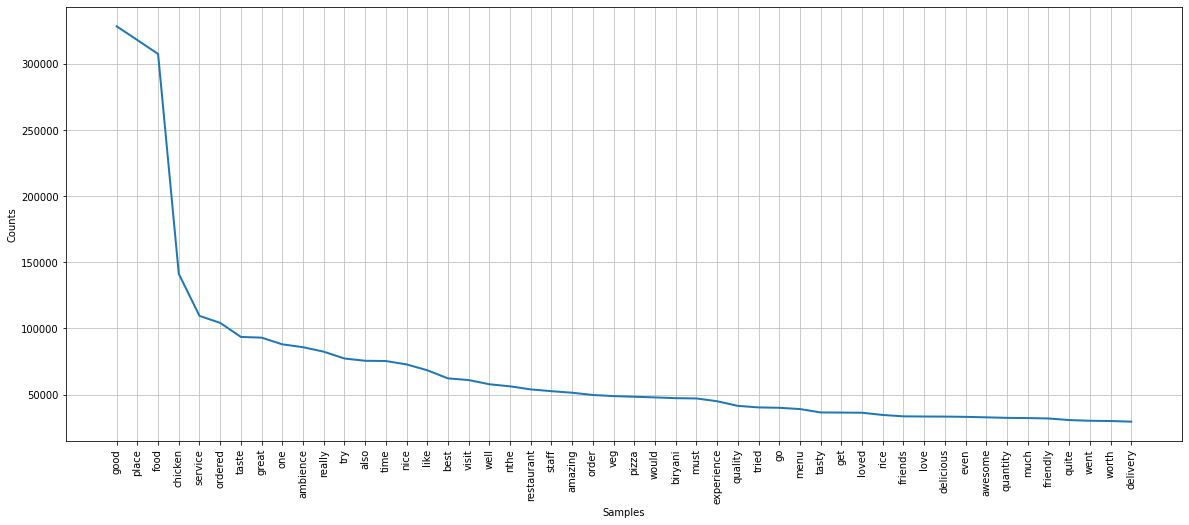

In [47]:
# Plotting the top 50 most frequent words
plt.figure(figsize = (20, 8))
fd.plot(50)

   Factors contributing to restaurant experience are mentioned in the following (descending) order of frequency:
   
   place > service > taste > ambience >time> staff > quality > menu  > quantity > friendly > delivery>.

**Bi-grams**

In [ ]:
##Now let us repeat the analysis on a bi-gram level. Bi-grams are pairs of words that provide better insights than individual words.

In [48]:
from nltk import bigrams
# Generating bigrams from the reviews
bigrams = bigrams(cleaned_reviews)

# Getting the bigram frequency distribution
fd_bigrams = FreqDist()
for bigram in bigrams:
    fd_bigrams[bigram]=fd_bigrams[bigram] + 1
    
# Examining the top 5 most frequent bigrams
fd_bigrams.most_common(5)

[(('must', 'try'), 23182),
 (('really', 'good'), 22564),
 (('good', 'food'), 21597),
 (('food', 'good'), 21192),
 (('good', 'place'), 18695)]

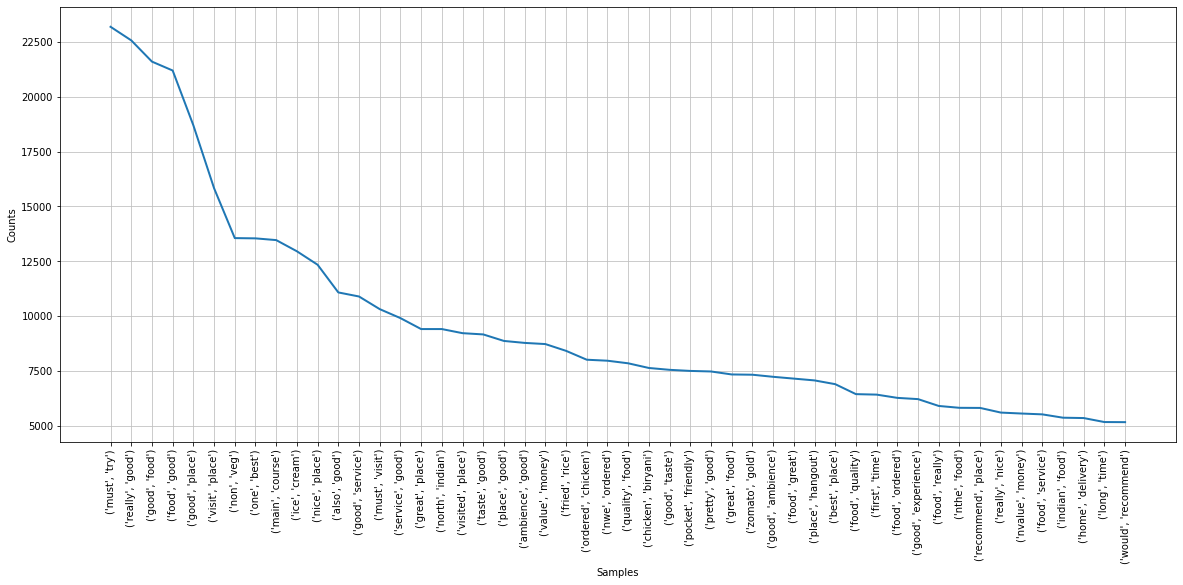

In [49]:
# Plotting the top 50 most frequent bigrams
plt.figure(figsize = (20, 8))
fd_bigrams.plot(50)


**Observations:**

**We have some new insights! Food items/preferences mentioned in the top 50 bigrams are non veg, ice cream, North Indian,
chicken biryani
Factors contributing to restaurant experience are : good food > good place > good service > value (for) money > pocket
friendly > ambience good.**

In [50]:
fd_bigrams.most_common(50)

[(('must', 'try'), 23182),
 (('really', 'good'), 22564),
 (('good', 'food'), 21597),
 (('food', 'good'), 21192),
 (('good', 'place'), 18695),
 (('visit', 'place'), 15832),
 (('non', 'veg'), 13561),
 (('one', 'best'), 13549),
 (('main', 'course'), 13470),
 (('ice', 'cream'), 12961),
 (('nice', 'place'), 12348),
 (('also', 'good'), 11087),
 (('good', 'service'), 10902),
 (('must', 'visit'), 10327),
 (('service', 'good'), 9918),
 (('great', 'place'), 9419),
 (('north', 'indian'), 9419),
 (('visited', 'place'), 9232),
 (('taste', 'good'), 9175),
 (('place', 'good'), 8878),
 (('ambience', 'good'), 8789),
 (('value', 'money'), 8736),
 (('fried', 'rice'), 8427),
 (('ordered', 'chicken'), 8023),
 (('nwe', 'ordered'), 7978),
 (('quality', 'food'), 7860),
 (('chicken', 'biryani'), 7647),
 (('good', 'taste'), 7563),
 (('pocket', 'friendly'), 7513),
 (('pretty', 'good'), 7488),
 (('great', 'food'), 7352),
 (('zomato', 'gold'), 7340),
 (('good', 'ambience'), 7245),
 (('food', 'great'), 7163),
 (('p

**Zomato might also be happy to know their membership program "Zomato Gold" is in the top 50 bigrams, with 7340 mentions in the customer reviews.**

**Trigrams**

In [51]:
from nltk import trigrams

In [52]:
# Generating trigrams from the reviews
trigrams = trigrams(cleaned_reviews)

fd_trigrams = FreqDist()
for trigram in trigrams:
    fd_trigrams[trigram] += 1

In [53]:
fd_trigrams.most_common(10)

[(('must', 'visit', 'place'), 3982),
 (('veg', 'non', 'veg'), 3734),
 (('north', 'indian', 'food'), 3433),
 (('place', 'hangout', 'friends'), 2824),
 (('food', 'really', 'good'), 2526),
 (('good', 'food', 'good'), 2212),
 (('place', 'hang', 'friends'), 1948),
 (('nfood', 'nambience', 'nservice'), 1931),
 (('peri', 'peri', 'chicken'), 1800),
 (('one', 'best', 'places'), 1788)]

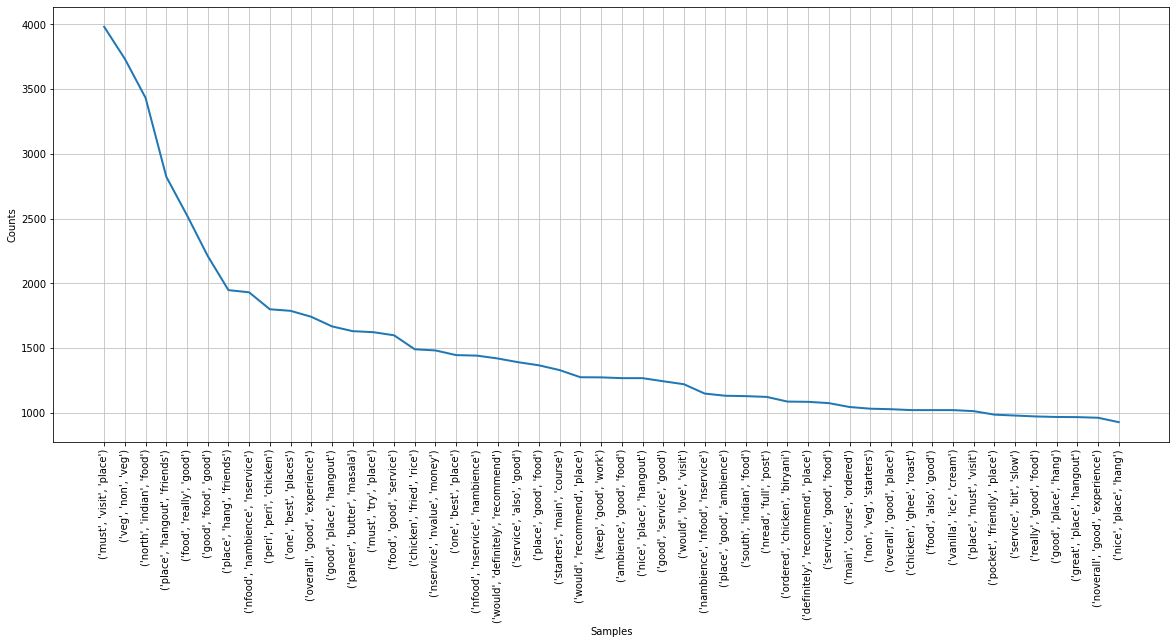

In [54]:
plt.figure(figsize = (20, 8))
fd_trigrams.plot(50)


In [55]:
newdata.head()

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,NaN,Fast Food,200,"[('rated 5.0', ""rated\n had an egg chicken ro...",[],Delivery,Bellandur,1
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('rated 4.0', 'rated\n this little cafe is s...",[],Delivery,BTM,1
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('rated 4.0', 'rated\n this little cafe is s...",[],Dine-out,BTM,1
3,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('rated 5.0', ""rated\n great service and don...",[],Buffet,Electronic City,NaN
4,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,NaN,"Continental, Chinese, Italian",700,"[('rated 5.0', ""rated\n great service and don...",[],Delivery,Electronic City,NaN


**Analysing your cuisines**

In [56]:
# Creating a new dataset with cuisines info and restaurant ratings
cuisines = newdata[["cuisines", "rating"]]
cuisines.head(3)



,cuisines,rating
0,Fast Food,1
1,"Fast Food, Beverages",1
2,"Fast Food, Beverages",1


In [57]:
cuisines.isnull().sum()

cuisines      23
rating      4524
dtype: int64

In [58]:
cuisines.dropna(inplace=True)

In [59]:
# Converting to lowercase
cuisines["cuisines"] = cuisines["cuisines"].apply(lambda x: x.lower())
# Tokenizing the cuisines
cuisine_tokens = cuisines["cuisines"].apply(tokenizer.tokenize)


In [60]:
cuisine_tokens[0]

['fast', 'food']

In [61]:
type(cuisine_tokens[0])

list

In [62]:
type(cuisine_tokens)

pandas.core.series.Series

In [63]:
# Concatenating all the cuisine names into one text document
all_cuisines = cuisine_tokens.astype(str).str.cat()
cleaned_cuisines = tokenizer.tokenize(all_cuisines)

In [64]:
type(cleaned_cuisines)

list

In [65]:
# Generating cuisine frequencies 
fd_cuisine = FreqDist()
for cuisine in cleaned_cuisines:
    fd_cuisine[cuisine] += 1
    
# Printing the 5 most common cuisines (top 5)
print(fd_cuisine.most_common(5))

[('indian', 9622), ('north', 6941), ('chinese', 5143), ('food', 4239), ('south', 2650)]


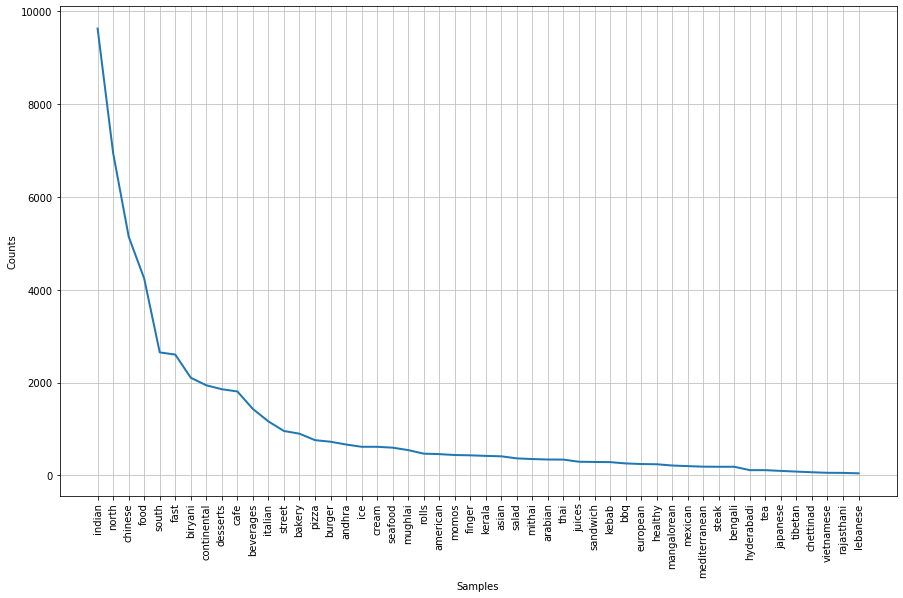

In [66]:
plt.figure(figsize=(15,9))
fd_cuisine.plot(50)

**Data Pre-processing**

In [67]:
newdata.columns

Index(['name', 'address', 'listed_in(type)_x', 'url', 'online_order',
       'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type',
       'dish_liked', 'cuisines', 'approx_cost(for two people)', 'reviews_list',
       'menu_item', 'listed_in(type)_y', 'listed_in(city)', 'rating'],
      dtype='object')

In [68]:
newdata.dtypes

name                             object
address                          object
listed_in(type)_x                object
url                              object
online_order                     object
book_table                       object
rate                             object
votes                             int64
phone                            object
location                         object
rest_type                        object
dish_liked                       object
cuisines                         object
approx_cost(for two people)      object
reviews_list                     object
menu_item                        object
listed_in(type)_y                object
listed_in(city)                  object
rating                         category
dtype: object

In [ ]:
#### considering "reviews_list", "menu_item", "dish_liked", "cuisines", u can think for predicting rating
### so we can store  ("reviews_list", "menu_item", "dish_liked", "cuisines") in a single feature

In [69]:
# Converting all the text to strings
newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]] = newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]].astype("str")

# Combining all the text data into a single feature called "text"
newdata["text"] = newdata["reviews_list"] + " " + newdata["menu_item"] + " " + newdata["dish_liked"] + " " + newdata["cuisines"]

In [70]:
newdata.head(5)

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating,text
0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...","[Delivery, Delivery]",https://www.zomato.com/bangalore/feeltheroll-b...,No,No,3.4/5,7,+91 9108342079\r\n+91 9886117901,Bellandur,Quick Bites,nan,Fast Food,200,"[('rated 5.0', ""rated\n had an egg chicken ro...",[],Delivery,Bellandur,1,"[('rated 5.0', ""rated\n had an egg chicken ro..."
1,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('rated 4.0', 'rated\n this little cafe is s...",[],Delivery,BTM,1,"[('rated 4.0', 'rated\n this little cafe is s..."
2,#L-81 Cafe,"Sector 6, HSR Layout, HSR","[Delivery, Dine-out, Delivery, Dine-out, Deliv...",https://www.zomato.com/bangalore/l-81-cafe-hsr...,Yes,No,3.9/5,48,+91 9986210891,HSR,Quick Bites,Burgers,"Fast Food, Beverages",400,"[('rated 4.0', 'rated\n this little cafe is s...",[],Dine-out,BTM,1,"[('rated 4.0', 'rated\n this little cafe is s..."
3,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,nan,"Continental, Chinese, Italian",700,"[('rated 5.0', ""rated\n great service and don...",[],Buffet,Electronic City,NaN,"[('rated 5.0', ""rated\n great service and don..."
4,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...","[Buffet, Delivery, Dine-out]",https://www.zomato.com/bangalore/vibes-restro-...,No,No,NaN,0,+91 9538911285,Electronic City,Casual Dining,nan,"Continental, Chinese, Italian",700,"[('rated 5.0', ""rated\n great service and don...",[],Delivery,Electronic City,NaN,"[('rated 5.0', ""rated\n great service and don..."


In [71]:
# Creating a new dataset with text and restaurant ratings
text_data = newdata[["text", "rating"]]
text_data.head()

,text,rating
0,"[('rated 5.0', ""rated\n had an egg chicken ro...",1
1,"[('rated 4.0', 'rated\n this little cafe is s...",1
2,"[('rated 4.0', 'rated\n this little cafe is s...",1
3,"[('rated 5.0', ""rated\n great service and don...",NaN
4,"[('rated 5.0', ""rated\n great service and don...",NaN


In [72]:
text_data['text'][0]

'[(\'rated 5.0\', "rated\\n  had an egg chicken roll and a paneer roll... really yummy... a must visit place... it would be good if you guys can keep the shop open on sunday\'s as well.. good luck... :-)"), (\'rated 5.0\', \'rated\\n  not just the roll but the filling tastes great. i would highly recommend to others to try their rolls. owners hospitality is also good and very friendly.\'), (\'rated 4.5\', \'rated\\n  very nice place complete value for money ? highly recommend.must visit for any foodie . i would recommend the egg chicken roll . #feeltheroll\'), (\'rated 5.0\', \'rated\\n  had an amazing mouth-watering ?chicken roll?worth every bite..a must try for every foodie?a variety of rolls and sandwiches are available as well .. a budding rafflesia ?\')] [] nan Fast Food'

   applying

    a.lowercase

    b.tokenization

    c.remove stopwords

    d.lemmatization **

In [73]:
# Converting text to lowercase
text_data["text"] = text_data["text"].apply(lambda x: x.lower())

In [74]:
text_data.shape

(20915, 2)

In [75]:
df=text_data.sample(n=2000)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df.head()

,text,rating
0,"[('rated 3.0', 'rated\n ordered hot and sour ...",1
1,"[('rated 2.0', 'rated\n avoid it guys not so ...",NaN
2,"[('rated 4.0', 'rated\n this review is based ...",1
3,"[] [] nan bakery, desserts",NaN
4,"[] [] nan north indian, chinese, biryani",NaN


In [76]:
df.isnull().sum()

text        0
rating    404
dtype: int64

In [77]:
df.dropna(inplace=True)

In [78]:
df.shape

(1596, 2)

In [79]:
# Tokenizing the text as we have to remove stopwords from data
tokens = df["text"].apply(tokenizer.tokenize) 
len(tokens)


1596

In [80]:
# Removing stopwords 
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])

**using lemitaizations**

In [81]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [82]:
from nltk.stem import WordNetLemmatizer

wl = WordNetLemmatizer()

def lem(text): # Writing a function to lemmatize words
  return [wl.lemmatize(word) for word in text]

In [83]:
# Applying the function to each row of the text
# i.e. reducing each word to its lemma
tokens_new = tokens.apply(lem)    

In [84]:
tokens_new.head()

0    [ordered, hot, sour, chicken, soup, junglee, c...
2    [review, based, take, away, nthis, one, place,...
6    [wanted, try, cupcake, could, reach, place, ca...
7    [love, place, like, dose, got, dilivery, late,...
8    [place, couple, time, fan, burrito, grilled, t...
Name: text, dtype: object

**Performing Feature Encoding**

In [85]:
df['rating'].dtype

CategoricalDtype(categories=['0', '1', '2'], ordered=True)

In [86]:
from sklearn.preprocessing import LabelEncoder

In [87]:
le=LabelEncoder()

In [88]:
df['rating']=le.fit_transform(df['rating'])

**Applying TF-IDF**

In [89]:
' '.join(tokens_new[0])

'ordered hot sour chicken soup junglee chicken friday evening soup okayish nothing hot sour manchow without noodle hell load black pepper junglee chicken egg curry piece nin taste food average seafood'

In [90]:
## collect entire data into corpus as we have to NLP techniques to this corpus to convert it into some vectors
corpus=[]
for i in tokens_new.index:
    review=' '.join(tokens_new[i])
    corpus.append(review)
    

In [91]:
# Creating the TF_IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(corpus).toarray()

In [92]:
X.shape

(1596, 23846)

**Applying Different machine learning algorithm**

**Logistic Regressions**

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
# Splitting the data into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, df['rating'], test_size = 0.3, random_state = 0,stratify=df['rating'])

In [95]:
from sklearn.linear_model import LogisticRegression

In [96]:
lr=LogisticRegression(multi_class='multinomial')

In [97]:
lr.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial')

In [98]:
# Make predictions.
predictions =lr.predict(X_test)

In [99]:
# Compute the error.
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions, y_test))

[[ 11   3   0]
 [ 80 318  45]
 [  0   4  18]]


In [100]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predictions,y_test))
print('\n')

0.7244258872651357




**Applying classification Algorithms**

In [101]:
#fit naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [102]:
### classifier models
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('Naive Bayes',GaussianNB()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))

In [103]:
# Make predictions on validation dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


for name, model in models:
    print(name)
    model.fit(X_train, y_train)
    
    # Make predictions.
    predictions = model.predict(X_test)

    # Compute the error.
    print(confusion_matrix(predictions, y_test))
    
    #accuracy score
    print(accuracy_score(predictions,y_test))
    print('\n')

LogisticRegression
[[ 11   3   0]
 [ 80 318  45]
 [  0   4  18]]
0.7244258872651357


Naive Bayes
[[ 16  36   1]
 [ 58 223  30]
 [ 17  66  32]]
0.5657620041753654


RandomForest
[[  7   0   0]
 [ 82 320  40]
 [  2   5  23]]
0.7306889352818372


Decision Tree
[[ 28  54   0]
 [ 60 246  40]
 [  3  25  23]]
0.6200417536534447


KNN
[[ 24  35   1]
 [ 59 257  29]
 [  8  33  33]]
0.6555323590814196




**cross validating my Logistic Regression model**

In [104]:
from sklearn.model_selection import cross_val_score

In [105]:
lr = LogisticRegression()
print(cross_val_score(lr, X, df['rating'], cv=5, scoring ='accuracy').mean())

0.7374862852664578
